# Data Fetching and Cleaning

### Pull SPY Data

In [18]:
import yfinance as yf
import os
import pandas as pd

In [19]:
ticker = "SPY"
start_date = "2015-01-01"
end_date = "2025-12-31"
csv_name = "spy.csv"
output_folder = "../data/raw"

In [20]:
spy = yf.Ticker(ticker)
data = spy.history(start=start_date, end=end_date)
data.index = pd.to_datetime(data.index, utc=True).date
data.index.name = 'Date'

output_path = os.path.join(output_folder, csv_name)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(0)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

data.to_csv(output_path, index=True)
print(f'Fetched data successfully.')

data.head()

Fetched data successfully.


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2015-01-02,171.378538,171.793740,169.551642,170.589645,121465900,0.0,0.0,0.0
2015-01-05,169.543303,169.709381,167.201575,167.508820,169632600,0.0,0.0,0.0
2015-01-06,167.816019,168.339177,165.133823,165.931015,209151400,0.0,0.0,0.0
2015-01-07,167.259706,168.339232,166.811294,167.998764,125346700,0.0,0.0,0.0
2015-01-08,169.410429,171.195802,169.393830,170.979889,147217800,0.0,0.0,0.0


In [21]:
# Do the same for S&P market data and 10-year bond data for the same time frame
sp_500 = yf.Ticker("^GSPC")
sp_500_data = sp_500.history(start=start_date, end=end_date)
sp_500_data.index = pd.to_datetime(sp_500_data.index, utc=True).date
sp_500_data.index.name = 'Date'
csv_name = "sp_500.csv"
output_path = os.path.join(output_folder, csv_name)
sp_500_data.to_csv(output_path, index=True)
print("Market data outputted to csv successfully.")

treasury_10yr = yf.Ticker("^TNX")
treasury_10yr_data = treasury_10yr.history(start=start_date, end=end_date)
treasury_10yr_data.index = pd.to_datetime(treasury_10yr_data.index, utc=True).date
treasury_10yr_data.index.name = 'Date'
csv_name = "treasury_10yr.csv"
output_path = os.path.join(output_folder, csv_name)
treasury_10yr_data.to_csv(output_path, index=True)
print("Treasury 10-year bond data outputted to csv successfully.")


Market data outputted to csv successfully.
Treasury 10-year bond data outputted to csv successfully.


We now need to clean up the SPY data by getting rid of the second and third row, and rename the first column to "Date" instead of "Price". In addition, we need to drop all NaN values. 

### Data Cleaning



In [22]:
# load data from raw data csv file
df = pd.read_csv("../data/raw/spy.csv", index_col=0, parse_dates=True)

# check column value types
print("Column data types:")
print(df.dtypes)
print()

# check if index is datetime
print(f"Index type: {type(df.index)}")
print(f"Is DatetimeIndex: {isinstance(df.index, pd.DatetimeIndex)}")
print()

Column data types:
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Dividends        float64
Stock Splits     float64
Capital Gains    float64
dtype: object

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Is DatetimeIndex: True



In [23]:
# drop dates with nan values
df = df[df.index.notna()]

# drop all nan values
df = df.dropna()

# sort by date
df = df.sort_index() 

# remove duplicates
df = df[~df.index.duplicated(keep='first')]

df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2015-01-02,171.378538,171.793740,169.551642,170.589645,121465900,0.0,0.0,0.0
2015-01-05,169.543303,169.709381,167.201575,167.508820,169632600,0.0,0.0,0.0
2015-01-06,167.816019,168.339177,165.133823,165.931015,209151400,0.0,0.0,0.0
2015-01-07,167.259706,168.339232,166.811294,167.998764,125346700,0.0,0.0,0.0
2015-01-08,169.410429,171.195802,169.393830,170.979889,147217800,0.0,0.0,0.0


#### Create train/test data split (70/30)

In [24]:
# count number of datapoints
total = len(df)
print(total)
print(0.7*total)

2765
1935.4999999999998


In [25]:
# so we will take the first 1935 rows as our training data
#  where we keep refining our parameters based on
# and the remaining 830 rows as our test data
cutoff = 1935
train = df.iloc[:cutoff]  # First 1935 rows
test = df.iloc[cutoff:]   # Remaining rows 
train.index.name = 'Date'
test.index.name = 'Date'

# check if we've separated correctly
print(len(train))
print(len(test))

1935
830


In [30]:
# store into the data/processed folder
train_data = "training_data_70.csv"
test_data = "test_data_30.csv"
output_folder = "../data/processed"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

train_output_path = os.path.join(output_folder, train_data)
test_output_path = os.path.join(output_folder, test_data)

train.to_csv(train_output_path, index=True)
test.to_csv(test_output_path, index=True)

In [31]:
# export cleaned SPY data 
# store into the data/processed folder
spy_data = "spy.csv"
output_folder = "../data/processed"

spy_output_path = os.path.join(output_folder, spy_data)

df.to_csv(spy_output_path, index=True)
print(f'SPY data sucessfully uploaded')

SPY data sucessfully uploaded


### Visualization

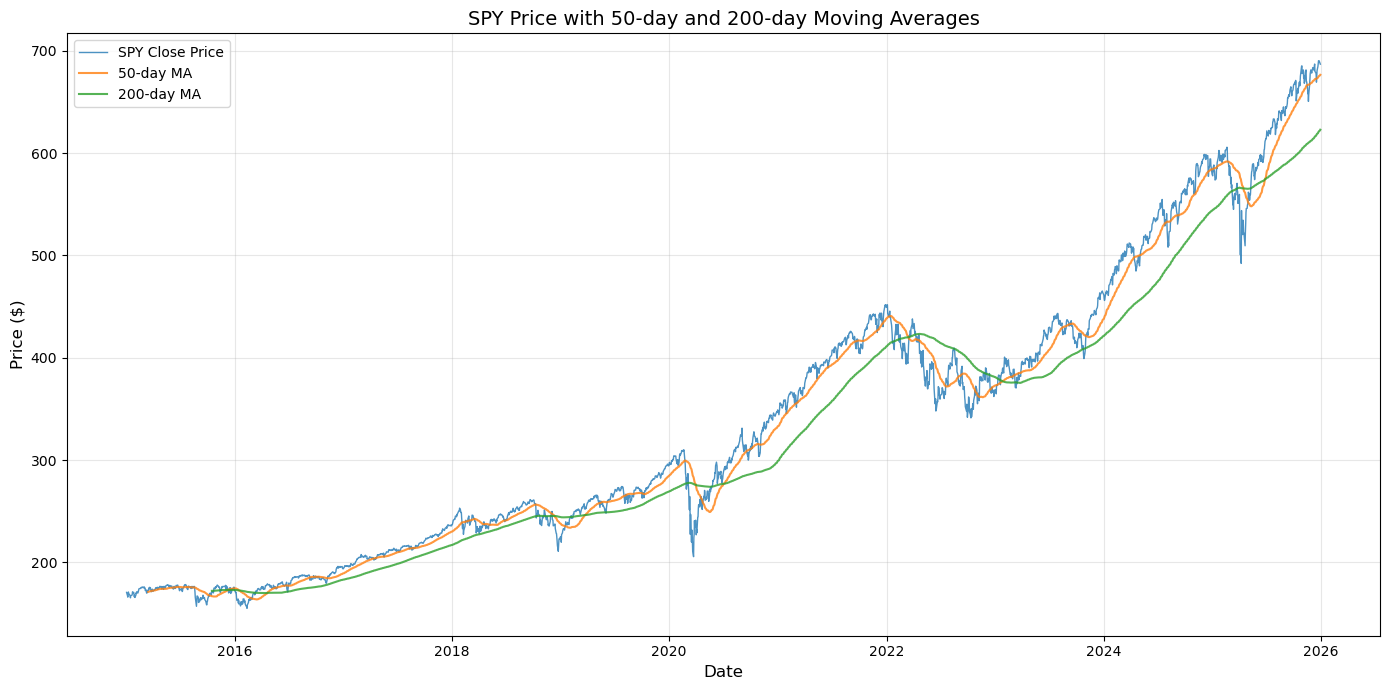

In [28]:
# plot the basic price series
import matplotlib.pyplot as plt

# Calculate moving averages
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_200'] = df['Close'].rolling(window=200).mean()

# Plot
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='SPY Close Price', linewidth=1, alpha=0.8)
plt.plot(df.index, df['MA_50'], label='50-day MA', linewidth=1.5, alpha=0.8)
plt.plot(df.index, df['MA_200'], label='200-day MA', linewidth=1.5, alpha=0.8)

plt.title('SPY Price with 50-day and 200-day Moving Averages', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

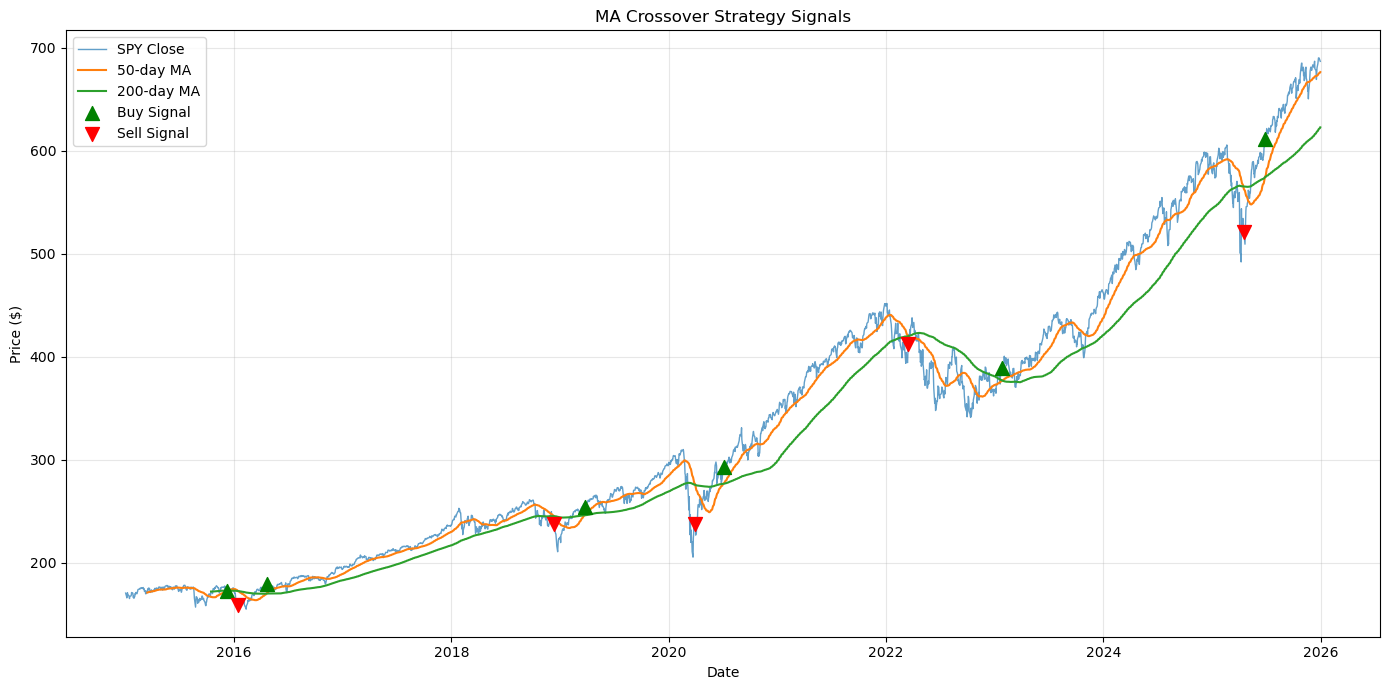

Bullish crossovers: 6
Bearish crossovers: 5


In [29]:
# Identify crossovers
df['signal'] = 0
df.loc[df['MA_50'] > df['MA_200'], 'signal'] = 1  # Bullish
df['crossover'] = df['signal'].diff()

bullish_cross = df[df['crossover'] == 1]  # Golden cross
bearish_cross = df[df['crossover'] == -1]  # Death cross

# Plot with crossover markers
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='SPY Close', linewidth=1, alpha=0.7)
plt.plot(df.index, df['MA_50'], label='50-day MA', linewidth=1.5)
plt.plot(df.index, df['MA_200'], label='200-day MA', linewidth=1.5)

# Mark crossovers
plt.scatter(bullish_cross.index, bullish_cross['Close'], 
           color='green', marker='^', s=100, label='Buy Signal', zorder=5)
plt.scatter(bearish_cross.index, bearish_cross['Close'], 
           color='red', marker='v', s=100, label='Sell Signal', zorder=5)

plt.title('MA Crossover Strategy Signals')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Bullish crossovers: {len(bullish_cross)}")
print(f"Bearish crossovers: {len(bearish_cross)}")

### Comment on MA crossovers

Immediately, we notice there are but 11 signals in total across the whole 10 years. This suggest low trade frequency and long holding periods under this strategy. However, the locations at which the bullish/bearish crossovers appear does make sense
- 2015-2016
- 2018-2019
- 2020: COVID
- 2022: Bear market
- 2023-2024: Market recovers from COVID
- April 2025: Tariff uncertainties

In the next Jupyter file, we will examine if this strategy is actually profitable and compare it against benchmarks.